In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)
root_path = '/content/gdrive/Othercomputers/My Computer/Fire_risk_main/Fire_risk_main/data/Fire-data-paper-hongru_share/'
data_path= root_path + '/github_repo/data/'


In [28]:
df_new.to_pickle(socio_raw_data + 'df_new_with_outcome.pkl')

In [ ]:


# df_new['ZIP']= df_new['ZIP5'].str[:5]  # Ensure ZIP is a string of length 5
# df_merged = pd.merge(df_new, city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], on='ZIP', how='lef  t')

# df_merged=df_merged.drop_duplicates(subset=[ 'ZIP5', 'accident_year','CBSA'])
# df_merged.shape
# cols_to_convert = ['total_population_list', 'Est_YRB_Built_total_units_list', 'RES_RATIO']
# df_merged[cols_to_convert] = df_merged[cols_to_convert].apply(pd.to_numeric, errors='coerce')
# df_merged['total_population'] = df_merged['total_population_list'] * df_merged['RES_RATIO']
# df_merged['total_households'] = df_merged['Est_YRB_Built_total_units_list'] * df_merged['RES_RATIO']

# df_merged_pop = (
#     df_merged
#     .groupby(['CBSA', 'accident_year'], as_index=False)   # group on both columns
#     .agg({
#         'total_population': 'sum',
#         'total_households': 'sum'
#     })
# )






In [51]:
import pandas as pd

# Step 1: Prepare the ZIP-level data
df_zip = df_new[['ZIP5', 'total_population_list', 'Est_YRB_Built_total_units_list','accident_year']].copy()
df_zip = df_zip.rename(columns={'ZIP5': 'ZIP'})

# Ensure numeric types
df_zip['total_population_list'] = pd.to_numeric(df_zip['total_population_list'], errors='coerce')
df_zip['Est_YRB_Built_total_units_list'] = pd.to_numeric(df_zip['Est_YRB_Built_total_units_list'], errors='coerce')

# Step 2: Merge with city-zip mapping
merged = pd.merge(df_zip, city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], on='ZIP', how='left')

# Apply RES_RATIO to population and units
merged['adj_population'] = merged['total_population_list'] * merged['RES_RATIO'].astype(float)
merged['adj_units'] = merged['Est_YRB_Built_total_units_list'] * merged['RES_RATIO'].astype(float)


# unique zip per CBSA per year
unique_zip= merged[['ZIP', 'CBSA','accident_year','adj_population','adj_units']].drop_duplicates()



# Step 3: Aggregate to CBSA level, no we get all pop and unit for all considered year
cbsa_aggregated = unique_zip.groupby('CBSA', as_index=False).agg({
    'adj_population': 'sum',
    'adj_units': 'sum'
})

# average over 11 years
cbsa_aggregated['adj_population'] = cbsa_aggregated['adj_population']/11
cbsa_aggregated['adj_units'] = cbsa_aggregated['adj_units']/11



# Step 4: Count fire events per CBSA
# Join CBSA code to each fire event based on ZIP
fire_events = pd.merge(df_new[['ZIP5', 'INCIDENT_KEY']], city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], 
                       left_on='ZIP5', right_on='ZIP', how='left')

# Adjust fire events using RES_RATIO to proportionally distribute one event to multiple CBSAs
fire_events['weighted_event'] = fire_events['RES_RATIO'].astype(float)

# Aggregate fire event count by CBSA
cbsa_fire_counts = fire_events.groupby('CBSA', as_index=False).agg({'weighted_event': 'sum'})

# Step 5: Merge demographic and fire data
cbsa_summary = pd.merge(cbsa_aggregated, cbsa_fire_counts, on='CBSA', how='left')
cbsa_summary['weighted_event'] = cbsa_summary['weighted_event'].fillna(0)

# Step 6: Compute fire rate per CBSA
cbsa_summary['fire_rate_per_100_000_year'] = cbsa_summary['weighted_event']/11 / cbsa_summary['adj_units'] * 100_000


In [ ]:
cbsa_summary.to_csv(socio_raw_data + '/cbsa_fire_rate_summary.txt', index=False, sep='\t')

cbsa_summary.to_csv(socio_raw_data + '/cbsa_fire_rate_summary.csv', index=False)


In [42]:
cbsa_summary=pd.read_csv(socio_raw_data + '/cbsa_fire_rate_summary.txt', sep='\t')


In [26]:
socio_raw_data

'f:\\OneDrive - Johns Hopkins\\2024_Chenzhi_Du_Fire_risk\\Fire_risk_main\\data\\hongru_share/nature cities/'

In [36]:
df_new.columns

Index(['STATE', 'INCIDENT_KEY', 'ZIP5', 'FIRE_SPRD', 'PROP_LOSS', 'PROP_VAL',
       'CONT_LOSS', 'CONT_VAL', 'FF_INJ', 'FF_DEATH', 'OTH_INJ', 'OTH_DEATH',
       'accident_year', 'accident_month', 'accident_day',
       'population_density_list', 'Est_YRB_Built_total_units_list',
       'total_loss', 'total_value'],
      dtype='object')

# fire outcomes

In [ ]:
# df_fs=pd.read_pickle(socio_raw_data + 'consequence/df_fs_github.pkl')
# df_inj=pd.read_pickle(socio_raw_data + 'consequence/df_inj_github.pkl')
# df_loss=pd.read_pickle(socio_raw_data + 'consequence/df_loss_github.pkl')
df_new=pd.read_pickle(socio_raw_data + 'df_new_with_outcome.pkl')

In [4]:
city_zip_mapping=pd.read_excel(socio_raw_data + '/zip_cbsa_122022.xlsx',dtype=str,sheet_name='ZIP_CBSA_122022')
unique_zip =city_zip_mapping[['ZIP', 'CBSA','RES_RATIO']].drop_duplicates()
df_new = df_new.merge(unique_zip, left_on=['ZIP5'],right_on=['ZIP'], how='left')


In [5]:
nan_0 = ['PROP_LOSS', 'PROP_VAL', 'CONT_LOSS', 'CONT_VAL','FF_INJ', 'FF_DEATH', 'OTH_INJ', 'OTH_DEATH']
df_new[nan_0] = df_new[nan_0].fillna(0)

# df_new['total_loss'] = df_new['total_loss'].fillna(0)
# df_new['total_value'] = df_new['total_value'].fillna(0)
df_new['total_loss'] = df_new['PROP_LOSS'].astype(int) + df_new['CONT_LOSS'].astype(int)
df_new['total_value'] = df_new['PROP_VAL'].astype(int) + df_new['CONT_VAL'].astype(int)


In [12]:
df_loss=df_new.copy()
df_loss = df_loss[df_loss['total_loss']>0]
threshold = df_loss['total_loss'].quantile(0.99)
df_loss = df_loss[df_loss['total_loss'] < threshold]

cpi_map={'2012':1,
         '2013':1.02,
         '2014':1.02,
         '2015':1.03,
         '2016':1.05,
         '2017':1.07,
         '2018':1.09,
         '2019':1.12,
         '2020':1.13,
         '2021':1.21,
         '2022':1.29
}
df_loss['total_loss'] = df_loss.apply(lambda row: row['total_loss'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)

df_loss['total_loss']= df_loss['total_loss'].astype(int)* df_loss['RES_RATIO'].astype(float)

df_loss['num_event']=df_loss['RES_RATIO'].astype(float)

df_loss_grouped = df_loss.groupby('CBSA').agg({
    'num_event': 'sum',
    'total_loss': 'sum'
}).reset_index()

df_loss_grouped['ave_loss_per_event'] = df_loss_grouped['total_loss'] / df_loss_grouped['num_event']
df_loss_grouped['num_event'].sum()


np.float64(750772.9999999999)

In [37]:
def compute_cbsa_risk_proportion(df_consequence, consequence_type, city_zip_mapping):
    # Count number of events in each Risk_Group per ZIP5
    zip_risk_counts = df_consequence.groupby(['ZIP5', 'Risk_Group']).size().reset_index(name='count')

    # Merge ZIP-level counts with city-ZIP mapping
    zip_risk_props = zip_risk_counts.rename(columns={'ZIP5': 'ZIP'})
    zip_risk_with_cbsa = pd.merge(zip_risk_props, city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], on='ZIP', how='left')

    # Adjust counts using RES_RATIO
    zip_risk_with_cbsa['adj_count'] = zip_risk_with_cbsa['count'] * zip_risk_with_cbsa['RES_RATIO'].astype(float)

    # Aggregate adjusted count at CBSA-Risk_Group level
    cbsa_risk_props = zip_risk_with_cbsa.groupby(['CBSA', 'Risk_Group'])['adj_count'].sum().reset_index()

    # Total adjusted count per CBSA
    cbsa_total = cbsa_risk_props.groupby('CBSA')['adj_count'].sum().reset_index(name='total_adj_count')

    # Merge and compute proportion
    df_cbsa_risk = pd.merge(cbsa_risk_props, cbsa_total, on='CBSA')
    df_cbsa_risk['risk_proportion'] = df_cbsa_risk['adj_count'] / df_cbsa_risk['total_adj_count']
    
    # Add consequence type
    df_cbsa_risk['consequence_type'] = consequence_type
    
    return df_cbsa_risk

In [38]:
df_fs=df_new.copy()
df_fs = df_fs[df_fs['FIRE_SPRD'].notna()]
df_fs['Risk_Group'] = df_fs['FIRE_SPRD']

df_fs_grouped = compute_cbsa_risk_proportion(df_fs, 'spread', city_zip_mapping)

df_fs_grouped=df_fs_grouped[df_fs_grouped['Risk_Group']=='2']

In [39]:
inj_specific=pd.read_pickle(socio_raw_data + 'inj_specific.pkl')
df_inj=df_new.copy()
df_inj=df_inj.merge(inj_specific, on='INCIDENT_KEY', how='inner')
vsl_proportion = [x * 1000 for x in [0.003, 0.047, 0.266, 0.593, 1]]

df_inj['vsl_proportion'] = (
    df_inj['SEV_1'] * vsl_proportion[0] +
    df_inj['SEV_2'] * vsl_proportion[1] +
    df_inj['SEV_3'] * vsl_proportion[2] +
    df_inj['SEV_4'] * vsl_proportion[3] +
    df_inj['SEV_5'] * vsl_proportion[4]
)

df_inj['num_event']=df_inj['RES_RATIO'].astype(float)

df_inj_grouped = df_inj.groupby('CBSA').agg({
    'num_event': 'sum',
    'vsl_proportion': 'sum'
}).reset_index()

df_inj_grouped['ave_vsl_per_event'] = df_inj_grouped['vsl_proportion'] / df_inj_grouped['num_event']
df_inj_grouped['ave_vsl_per_event']=df_inj_grouped['ave_vsl_per_event'].astype(float)
df_inj_grouped['num_event'].sum()


np.float64(48647.0)

In [40]:
df_inj_grouped.columns

Index(['CBSA', 'num_event', 'vsl_proportion', 'ave_vsl_per_event'], dtype='object')

In [44]:
cbsa_summary['CBSA']=cbsa_summary['CBSA'].astype(str)

# combine ignition rate and three consequence

In [45]:
final_fire_matrix=cbsa_summary.merge(df_fs_grouped[['CBSA','risk_proportion',]], on='CBSA', how='left')
final_fire_matrix=final_fire_matrix.merge(df_loss_grouped[['CBSA', 'num_event', 'total_loss', 'ave_loss_per_event']], on='CBSA', how='left')
final_fire_matrix=final_fire_matrix.merge(df_inj_grouped[['CBSA','num_event', 'vsl_proportion', 'ave_vsl_per_event']], on='CBSA', how='left',suffixes=('_loss','_inj'))
final_fire_matrix.rename(columns={'risk_proportion': 'fire_spread_2'}, inplace=True)
final_fire_matrix['fs_larger2']=1-final_fire_matrix['fire_spread_2']


In [49]:
final_fire_matrix.to_csv(socio_raw_data+'final_fire_matrix.csv',index=False)
final_fire_matrix.to_pickle(socio_raw_data+'final_fire_matrix.pkl')

# calculate ranking


In [46]:
cbsa_county_mapping = pd.read_excel(socio_raw_data + '/list1_2023.xlsx', header=None, dtype=str)

# Set column names using the second row
cbsa_county_mapping.columns = cbsa_county_mapping.iloc[2]

# Drop the first two rows (original header and the new column names row)
cbsa_county_mapping = cbsa_county_mapping.drop(index=[0, 1,2]).reset_index(drop=True)

cbsa_name= cbsa_county_mapping[['CBSA Code', 'CBSA Title',
       'Metropolitan/Micropolitan Statistical Area',]].drop_duplicates()

In [ ]:
final_fire_matrix=pd.read_pickle(socio_raw_data+'final_fire_matrix.pkl')
final_fire_matrix=final_fire_matrix.merge(cbsa_name, left_on='CBSA', right_on='CBSA Code', how='left')
final_fire_matrix['rank_pop'] = final_fire_matrix['adj_population'].rank(ascending=False, method='min')
final_fire_matrix=final_fire_matrix[final_fire_matrix['rank_pop'] <=300]
final_fire_matrix['adj_population'].min()

In [48]:

final_fire_matrix['rank_ign'] = final_fire_matrix['fire_rate_per_100_000_year'].rank(ascending=False, method='min')
final_fire_matrix['rank_ave_loss_per_event'] = final_fire_matrix['ave_loss_per_event'].rank(ascending=False, method='min')
final_fire_matrix['rank_ave_vsl_per_event'] = final_fire_matrix['ave_vsl_per_event'].rank(ascending=False, method='min')
final_fire_matrix['rank_fs_larger2'] = final_fire_matrix['fs_larger2'].rank(ascending=False, method='min')



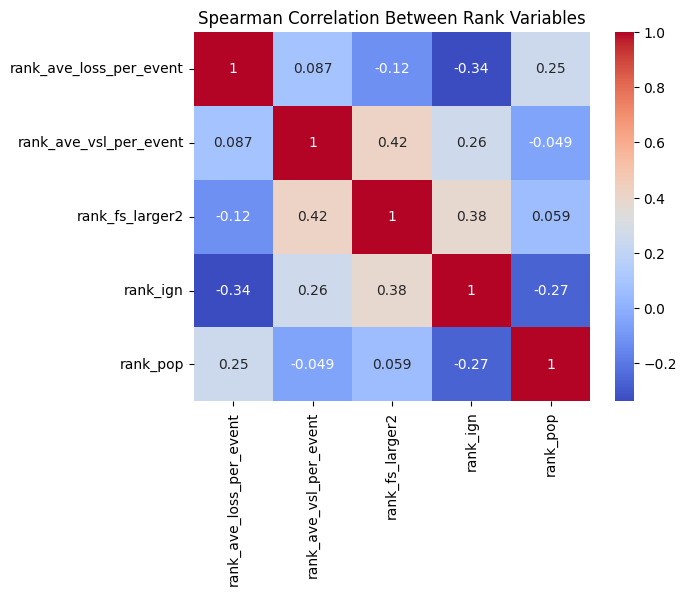

In [22]:
#correlation check
rank_cols = ['rank_ave_loss_per_event', 'rank_ave_vsl_per_event', 'rank_fs_larger2','rank_ign','rank_pop']
correlation_matrix = final_fire_matrix[rank_cols].corr(method='spearman')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Between Rank Variables")
plt.show()

In [ ]:
# aggregate to CBSA level
def aggregate_to_cbsa(df, absolute_features, proportion_features, weather_features):
    df = df.copy()
    df['total_population'] = df['total_population_list'] * df['RES_RATIO']
    df['total_households'] = df['Est_YRB_Built_total_units_list'] * df['RES_RATIO']
    cbsa_group = df.groupby(['CBSA', 'accident_year'])

    results = []

    for (cbsa, year), group in cbsa_group:
        result = {'CBSA': cbsa, 'accident_year': year}
        for feat in absolute_features:
            result[feat] = (group[feat] * group['RES_RATIO']).sum()

        for feat in proportion_features:
            if feat in building_feature:
                base = group['total_households'].sum()
                value = (group[feat] * group['total_households']).sum()
            else:
                base = group['total_population'].sum()
                value = (group[feat] * group['total_population']).sum()
            result[feat] = value / base if base > 0 else None

        # for feat in weather_features:
        #     weighted = (group[feat] * group['RES_RATIO']).sum()
        #     weight_sum = group['RES_RATIO'].sum()
        #     result[feat] = weighted / weight_sum if weight_sum > 0 else None

        results.append(result)

    return pd.DataFrame(results)

# old data process

In [5]:

df_label = df_inj.copy()
#vsl_proportion = [x * 1000 for x in [0.003, 0.047, 0.105, 0.266, 1]]
vsl_proportion = [x * 1000 for x in [0.003, 0.047, 0.266, 0.593, 1]]


#vsl_proportion = [1,4,9,16,25]


# Multiply each column by its corresponding value in vsl_proportion
df_label['vsl_proportion'] = (
    df_label['SEV_1'] * vsl_proportion[0] +
    df_label['SEV_2'] * vsl_proportion[1] +
    df_label['SEV_3'] * vsl_proportion[2] +
    df_label['SEV_4'] * vsl_proportion[3] +
    df_label['SEV_5'] * vsl_proportion[4]
)

#thresholds = df_label['vsl_proportion'].quantile([0.4, 0.6, 0.8])
thresholds = df_label['vsl_proportion'].quantile([0.4,0.75])

print(thresholds)

bins = [0, thresholds[0.4],  thresholds[0.75],float('inf')]

#labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
labels = ['0', '1', '2']
# Assign risk groups based on the thresholds
df_inj['Risk_Group'] = pd.cut(df_label['vsl_proportion'], bins=bins, labels=labels, include_lowest=True)
df_inj['vsl_proportion'] = df_label['vsl_proportion']

0.40      6.0
0.75    593.0
Name: vsl_proportion, dtype: float64


In [6]:
thresholds = df_loss['total_loss'].quantile([0.4, 0.75])

print(thresholds)
#bins = [-float('inf'), thresholds[0.5], thresholds[0.75], thresholds[0.9], float('inf')]
bins = [-float('inf'), thresholds[0.4], thresholds[0.75], float('inf')]

#labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
labels = ['0', '1', '2']

df_loss['Risk_Group'] = pd.cut(df_loss['total_loss'], bins=bins, labels=labels, include_lowest=True)

0.40    10661.157025
0.75    67755.140187
Name: total_loss, dtype: float64


In [54]:
df_fs=df_fs.merge(df_new[['INCIDENT_KEY','ZIP5','Est_YRB_Built_total_units_list']], on='INCIDENT_KEY', how='left')
df_inj=df_inj.merge(df_new[['INCIDENT_KEY','ZIP5','Est_YRB_Built_total_units_list']], on='INCIDENT_KEY', how='left')
df_loss=df_loss.merge(df_new[['INCIDENT_KEY','ZIP5','Est_YRB_Built_total_units_list']], on='INCIDENT_KEY', how='left')



In [55]:
df_fs['Risk_Group']=df_fs['FIRE_SPRD'].astype(str)

In [60]:
columns_to_copy_consequence=['ZIP5', 'INCIDENT_KEY', 'accident_year', 'Risk_Group','Est_YRB_Built_total_units_list']
df_fs_consequence=df_fs[columns_to_copy_consequence].copy()
df_inj_consequence=df_inj[columns_to_copy_consequence].copy()
df_loss_consequence=df_loss[columns_to_copy_consequence].copy()

In [ ]:
# Count number of events in each Risk_Group per ZIP5
zip_risk_counts = df_fs_consequence.groupby(['ZIP5', 'Risk_Group']).size().reset_index(name='count')

# Total events per ZIP5

# Merge to get CBSA and RES_RATIO
zip_risk_props = zip_risk_counts.rename(columns={'ZIP5': 'ZIP'})
zip_risk_with_cbsa = pd.merge(zip_risk_props, city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], on='ZIP', how='left')

# Adjust the risk group proportion based on RES_RATIO
zip_risk_with_cbsa['adj_count'] = zip_risk_with_cbsa['count'] * zip_risk_with_cbsa['RES_RATIO'].astype(float)

# Group by CBSA and Risk_Group
cbsa_risk_props = zip_risk_with_cbsa.groupby(['CBSA', 'Risk_Group'])['adj_count'].sum().reset_index()

# Step 1: Calculate total adjusted count per CBSA
cbsa_total = cbsa_risk_props.groupby('CBSA')['adj_count'].sum().reset_index(name='total_adj_count')

# Step 2: Merge with original data to get proportion
df_cbsa_risk = pd.merge(cbsa_risk_props, cbsa_total, on='CBSA')
df_cbsa_risk['risk_proportion'] = df_cbsa_risk['adj_count'] / df_cbsa_risk['total_adj_count']



In [73]:
def compute_cbsa_risk_proportion(df_consequence, consequence_type, city_zip_mapping):
    # Count number of events in each Risk_Group per ZIP5
    zip_risk_counts = df_consequence.groupby(['ZIP5', 'Risk_Group']).size().reset_index(name='count')

    # Merge ZIP-level counts with city-ZIP mapping
    zip_risk_props = zip_risk_counts.rename(columns={'ZIP5': 'ZIP'})
    zip_risk_with_cbsa = pd.merge(zip_risk_props, city_zip_mapping[['ZIP', 'CBSA', 'RES_RATIO']], on='ZIP', how='left')

    # Adjust counts using RES_RATIO
    zip_risk_with_cbsa['adj_count'] = zip_risk_with_cbsa['count'] * zip_risk_with_cbsa['RES_RATIO'].astype(float)

    # Aggregate adjusted count at CBSA-Risk_Group level
    cbsa_risk_props = zip_risk_with_cbsa.groupby(['CBSA', 'Risk_Group'])['adj_count'].sum().reset_index()

    # Total adjusted count per CBSA
    cbsa_total = cbsa_risk_props.groupby('CBSA')['adj_count'].sum().reset_index(name='total_adj_count')

    # Merge and compute proportion
    df_cbsa_risk = pd.merge(cbsa_risk_props, cbsa_total, on='CBSA')
    df_cbsa_risk['risk_proportion'] = df_cbsa_risk['adj_count'] / df_cbsa_risk['total_adj_count']
    
    # Add consequence type
    df_cbsa_risk['consequence_type'] = consequence_type
    
    return df_cbsa_risk

# Apply the function to all three datasets
df_fs_result = compute_cbsa_risk_proportion(df_fs_consequence, 'fire_spread', city_zip_mapping)
df_inj_result = compute_cbsa_risk_proportion(df_inj_consequence, 'injury', city_zip_mapping)
df_loss_result = compute_cbsa_risk_proportion(df_loss_consequence, 'loss', city_zip_mapping)

# Combine into one DataFrame
df_all_cbsa_risk = pd.concat([df_fs_result, df_inj_result, df_loss_result], ignore_index=True)


C:\Users\Malcolm\AppData\Local\Temp\ipykernel_16572\2510543554.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zip_risk_counts = df_consequence.groupby(['ZIP5', 'Risk_Group']).size().reset_index(name='count')
C:\Users\Malcolm\AppData\Local\Temp\ipykernel_16572\2510543554.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cbsa_risk_props = zip_risk_with_cbsa.groupby(['CBSA', 'Risk_Group'])['adj_count'].sum().reset_index()
C:\Users\Malcolm\AppData\Local\Temp\ipykernel_16572\2510543554.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas

In [77]:
df_all_cbsa_risk.to_csv(socio_raw_data + '/cbsa_consequence_summary.txt', index=False, sep='\t')

In [ ]:
columns_to_copy=['STATE', 'INCIDENT_KEY', 'ZIP5', 'accident_year', 'accident_month', 'accident_day', 'population_density_list', 'Est_YRB_Built_total_units_list','']
df_consequence=df[columns_to_copy].copy()

In [4]:
cbsa_pop = pd.read_csv(socio_raw_data + '/csa-est2024-alldata.csv', dtype=str, encoding='latin1')


In [5]:
selected_cbsa_pop= cbsa_pop[cbsa_pop['LSAD']=='Metropolitan Statistical Area'].copy()

In [21]:
selected_cbsa_pop['CBSA'] = selected_cbsa_pop ['CBSA'].astype('int64')
selected_cbsa_pop['POPESTIMATE2024']=selected_cbsa_pop['POPESTIMATE2024'].astype('int64')

In [22]:
selected_cbsa_pop.columns

Index(['CSA', 'CBSA', 'MDIV', 'STCOU', 'NAME', 'LSAD', 'ESTIMATESBASE2020',
       'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022',
       'POPESTIMATE2023', 'POPESTIMATE2024', 'NPOPCHG2020', 'NPOPCHG2021',
       'NPOPCHG2022', 'NPOPCHG2023', 'NPOPCHG2024', 'BIRTHS2020', 'BIRTHS2021',
       'BIRTHS2022', 'BIRTHS2023', 'BIRTHS2024', 'DEATHS2020', 'DEATHS2021',
       'DEATHS2022', 'DEATHS2023', 'DEATHS2024', 'NATURALCHG2020',
       'NATURALCHG2021', 'NATURALCHG2022', 'NATURALCHG2023', 'NATURALCHG2024',
       'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021', 'INTERNATIONALMIG2022',
       'INTERNATIONALMIG2023', 'INTERNATIONALMIG2024', 'DOMESTICMIG2020',
       'DOMESTICMIG2021', 'DOMESTICMIG2022', 'DOMESTICMIG2023',
       'DOMESTICMIG2024', 'NETMIG2020', 'NETMIG2021', 'NETMIG2022',
       'NETMIG2023', 'NETMIG2024', 'RESIDUAL2020', 'RESIDUAL2021',
       'RESIDUAL2022', 'RESIDUAL2023', 'RESIDUAL2024'],
      dtype='object')

In [39]:
fire_consequence=pd.read_csv(socio_raw_data + '/cbsa_consequence_summary.txt', sep='\t')

In [40]:
fire_rate=pd.read_csv(socio_raw_data + '/cbsa_fire_rate_summary.txt', sep='\t')

In [42]:
fire_consequence=fire_consequence.merge(selected_cbsa_pop[['CBSA', 'POPESTIMATE2024','NAME']], on='CBSA', how='left')
fire_rate=fire_rate.merge(selected_cbsa_pop[['CBSA', 'POPESTIMATE2024','NAME']], on='CBSA', how='left')

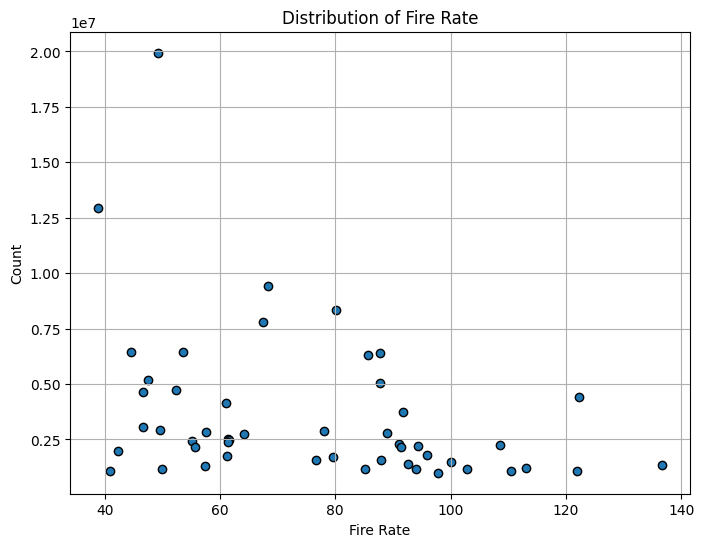

In [43]:
fire_rate_selected = fire_rate.sort_values(by='POPESTIMATE2024', ascending=False).head(50)

plt.figure(figsize=(8,6))
plt.scatter(fire_rate_selected['fire_rate_per_100_000_year'].dropna(),fire_rate_selected['POPESTIMATE2024'].dropna(),  edgecolor='black')
plt.xlabel('Fire Rate')
plt.ylabel('Count')
plt.title('Distribution of Fire Rate')
plt.grid(True)
plt.show()

In [44]:
fire_consequence_selected=fire_consequence[fire_consequence['Risk_Group']==2].copy()

In [45]:
fire_consequence_selected_fs=fire_consequence_selected[fire_consequence_selected['consequence_type']=='fire_spread'].copy()
fire_consequence_selected_inj=fire_consequence_selected[fire_consequence_selected['consequence_type']=='injury'].copy()
fire_consequence_selected_loss=fire_consequence_selected[fire_consequence_selected['consequence_type']=='loss'].copy()

In [46]:

fire_consequence_selected_fs_50=fire_consequence_selected_fs.sort_values(by='POPESTIMATE2024', ascending=False).head(50)
fire_consequence_selected_inj_50=fire_consequence_selected_inj.sort_values(by='POPESTIMATE2024', ascending=False).head(50)
fire_consequence_selected_loss_50=fire_consequence_selected_loss.sort_values(by='POPESTIMATE2024', ascending=False).head(50)


In [47]:
#save to csv
fire_consequence_selected_fs_50.to_csv(socio_raw_data + '/fire_consequence_selected_fs_50.csv', index=False, sep=',')
fire_consequence_selected_inj_50.to_csv(socio_raw_data + '/fire_consequence_selected_inj_50.csv', index=False, sep=',')
fire_consequence_selected_loss_50.to_csv(socio_raw_data + '/fire_consequence_selected_loss_50.csv', index=False, sep=',')
fire_rate_selected.to_csv(socio_raw_data + '/fire_rate_selected_50.csv', index=False, sep=',')